In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

c:\Python310\lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [2]:
data = pd.read_csv("Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
61084,There was a small Ram krishna temple,वहाँ रामकृष्ण का छोटा सा मन्दिर था।
3730,"If there is more than one arbitrator , the par...",यदि एक से अधिक मध्यस्थ हैं तो विवादी पक्षों को...
18610,* Or use another interdental cleaning device .,* या दाँतों के बीच सफाई करने का कोई अन्य उपकरण...
104603,"You go from drug formulation, lab testing, ani...","आप दवा तैयार करने, प्रयोगशाला परीक्षण, पशु परी..."
63287,By further selection many fully fertile Armadi...,अधिक उचित चयन करने के पश्चात कई संपूर्णत : जनन...


In [3]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [4]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

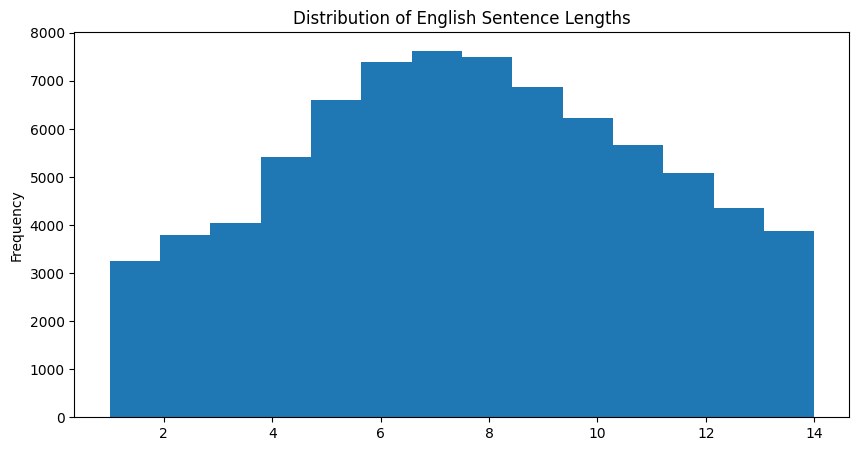

In [5]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [6]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [7]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [8]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[7, 82, 83, 62, 8266, 26951, 0, 0], [94, 104, 110, 2144], [123, 104, 183, 306]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27205, 122, 123, 124, 3305, 28591, 5206, 0], [143, 111, 14354, 80], [404, 433, 114, 80]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [9]:
EMBED_DIM = 256
HIDDEN_DIM = 512
BATCH_SIZE = 128

In [10]:
data, test_data = train_test_split(data, test_size=0.05)
len(data), len(test_data)

(73855, 3888)

In [11]:
# shuffle data
print(data.head())
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

                                                 English  \
25614  hiroshima became a symbol of this conflict . . ..   
24361                              i spend a lot of time   
6684   in the evening of diwali they worship lord gan...   
71334                                dictrict of lucknow   
38519  they do not see the selection process imposing...   

                                                   Hindi  
25614         हिरोशिमा इस संघर्ष का प्रतीक बन गया . . ..  
24361                             मेरा काफ़ी समय जाता है  
6684   दीपावली की शाम लक्ष्मी और गणेश जी की पूजा की ज...  
71334                                          लखनऊ जिला  
38519  उन्हें यह भी नहीं लगता कि उमीदवारों का चयन सोन...  
                                             English  \
0                          starting from kinematics.   
1  food constituents different kinds of foods are...   
2  these points towards four rivers of heaven nd ...   
3                i removed the microphone from that,   
4    

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(MyDataset(test_data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM)
        self.rnn = nn.GRU(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)

    def forward(self, src):
        """
        src: (batch_size, src_len)
        """
        embedded = self.embedding(src)               # (B, T, E)
        outputs, hidden = self.rnn(embedded)         # outputs: all h_t, hidden: last h_T
        return outputs, hidden                       # hidden = context vector

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, EMBED_DIM)
        self.rnn = nn.GRU(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, output_dim)

    def forward(self, input_token, hidden):
        """
        input_token: (batch_size) → y_{t-1}
        hidden: context / previous hidden
        """
        input_token = input_token.unsqueeze(1)       # (B, 1)
        embedded = self.embedding(input_token)        # (B, 1, E)

        output, hidden = self.rnn(embedded, hidden)   # RNN step
        prediction = self.fc(output.squeeze(1))      # (B, vocab)

        return prediction, hidden

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: (B, src_len)
        trg: (B, trg_len)
        """
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
 
        _, hidden = self.encoder(src)     # CONTEXT VECTOR


        input_token = trg[:, 0]           # <start>

        for t in range(1, trg_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input_token = trg[:, t] if teacher_force else top1

        return outputs

In [16]:
encoder = Encoder(input_dim=eng_tokenizer.vocab_size+1)
decoder = Decoder(output_dim=hin_tokenizer.vocab_size+1)

model = Seq2Seq(encoder, decoder, device).to(device)


In [17]:
# # load saved weights and set model to evaluation mode
# checkpoint_path = "models/LSTM_stack_model_epoch_30_batch_401.pth"
# state_dict = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(state_dict)
# model.to(device)
# model.train()

In [ ]:
crition = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [19]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 100
history = []
losses_test = []

average_losses = []
average_losses_test = []

for epoch in range(EPOCHS):
    if epoch==20:optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    elif epoch==40:optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif epoch==60:optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    tqdm_bar = tqdm(dataset)

    for i, batch in enumerate(tqdm_bar):
        model.train()
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)
        # forward pass
        logits = model(X, y)
        loss = crition(logits.view(-1, logits.size(-1)), y.view(-1))
        la = 'UND' if len(history)<50 else f"{(sum(history[-50:])/50):.4f}"

        #flush
        # del batch, X, y, logits
        # torch.cuda.empty_cache()
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
        optimizer.step()


       

        tqdm_bar.set_postfix({"loss_avg": la, "current loss": f"{loss.item():.4f}"})
        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        history.append(loss.item())

        if len(history)>50:
            average_losses.append(sum(history[-50:])/50)
            average_losses_test.append(sum(losses_test[-50:])/50)
    
    k=0
    sumer=0
    for d in test_dataset:

        model.eval()
        tX, ty = d['eng_input'].to(device), d['hin_target'].to(device)
        # test loss
        test_logits = model(tX, ty)
        test_loss = crition(test_logits.view(-1, test_logits.size(-1)), ty.view(-1))
        # lat = 'UND' if len(losses_test)<50 else f"{(sum(losses_test[-50:])/50):.4f}"
        sumer+=test_loss.item()
        if len(history)>50:
            average_losses_test.append(sum(losses_test[-50:])/50)
        k+=1
        losses_test.append(test_loss.item())
    print("Average Test Loss: ",sumer/(k+0.00001))

        
    
    save_model(model, f"models/GRU_stack_model_epoch_{epoch+1}.pth")
    

Epoch: 1: 100%|██████████| 577/577 [04:10<00:00,  2.31it/s, loss_avg=176.4231, current loss=185.9492]


Average Test Loss:  184.47534972270094


Epoch: 2: 100%|██████████| 577/577 [04:10<00:00,  2.30it/s, loss_avg=238.6796, current loss=253.4414]


Average Test Loss:  245.41495989638392


Epoch: 3: 100%|██████████| 577/577 [04:10<00:00,  2.30it/s, loss_avg=357.7609, current loss=320.3937]


Average Test Loss:  355.58241959381377


Epoch: 4: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s, loss_avg=383.3481, current loss=386.4553]


Average Test Loss:  401.70697845326805


Epoch: 5: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=454.2330, current loss=452.4990]


Average Test Loss:  471.4971918903968


Epoch: 6: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=490.4225, current loss=450.1171]


Average Test Loss:  505.8344916048641


Epoch: 7: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=499.5844, current loss=525.3489]


Average Test Loss:  546.1322553507972


Epoch: 8: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=493.9225, current loss=538.0295]


Average Test Loss:  553.7073901378631


Epoch: 9: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=488.1808, current loss=482.1324]


Average Test Loss:  543.8673231413374


Epoch: 10: 100%|██████████| 577/577 [04:10<00:00,  2.30it/s, loss_avg=484.6872, current loss=443.2348]


Average Test Loss:  546.19601737975


Epoch: 11: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s, loss_avg=504.0132, current loss=478.4834]


Average Test Loss:  575.7784407377384


Epoch: 12: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s, loss_avg=535.9583, current loss=525.1257]


Average Test Loss:  617.2086317031128


Epoch: 13: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=535.5164, current loss=591.0181]


Average Test Loss:  647.4437776091771


Epoch: 14: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=571.5682, current loss=566.0999]


Average Test Loss:  668.4774238372978


Epoch: 15: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=603.0001, current loss=606.2416]


Average Test Loss:  723.337019374651


Epoch: 16: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s, loss_avg=603.4984, current loss=625.4566]


Average Test Loss:  720.0528072756821


Epoch: 17: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=591.0799, current loss=565.5535]


Average Test Loss:  698.1756761334765


Epoch: 18: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=612.4737, current loss=575.9013]


Average Test Loss:  733.5455850237277


Epoch: 19: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=627.1842, current loss=599.0679]


Average Test Loss:  743.0135365436424


Epoch: 20: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s, loss_avg=711.2061, current loss=669.4060]


Average Test Loss:  827.5303687654052


Epoch: 21: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=408.9523, current loss=379.9946]


Average Test Loss:  555.788347679162


Epoch: 22: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=336.9107, current loss=319.6092]


Average Test Loss:  485.8635783457333


Epoch: 23: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=291.0162, current loss=225.7719]


Average Test Loss:  445.144109059171


Epoch: 24: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=255.1790, current loss=274.8029]


Average Test Loss:  413.9292015456457


Epoch: 25: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=231.9050, current loss=236.5318]


Average Test Loss:  391.2627551574908


Epoch: 26: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=209.5991, current loss=237.7775]


Average Test Loss:  371.7400445637583


Epoch: 27: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=187.7479, current loss=163.1316]


Average Test Loss:  358.9724833550205


Epoch: 28: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s, loss_avg=173.5302, current loss=177.3770]


Average Test Loss:  342.71925964134266


Epoch: 29: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=153.9475, current loss=132.1391]


Average Test Loss:  333.95181035261663


Epoch: 30: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=147.7657, current loss=121.1585]


Average Test Loss:  319.52865925140276


Epoch: 31: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=139.7106, current loss=160.7906]


Average Test Loss:  317.82213307637215


Epoch: 32: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=131.1420, current loss=103.3985]


Average Test Loss:  307.20845359943405


Epoch: 33: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=122.4895, current loss=118.5747]


Average Test Loss:  303.1659094618223


Epoch: 34: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=113.1311, current loss=118.5551]


Average Test Loss:  296.79263526866225


Epoch: 35: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=110.5389, current loss=104.8819]


Average Test Loss:  294.06780232077574


Epoch: 36: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=103.8143, current loss=106.7162]


Average Test Loss:  290.5549959155066


Epoch: 37: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=98.7974, current loss=115.0196] 


Average Test Loss:  287.6185679312898


Epoch: 38: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=94.5730, current loss=109.5658] 


Average Test Loss:  283.2887136860059


Epoch: 39: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=87.3255, current loss=95.2021] 


Average Test Loss:  283.7970462975128


Epoch: 40: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=89.4737, current loss=84.7769] 


Average Test Loss:  286.30843740396926


Epoch: 41: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=84.0804, current loss=70.7929] 


Average Test Loss:  279.1512869830778


Epoch: 42: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=81.0893, current loss=69.1909] 


Average Test Loss:  278.1843240499786


Epoch: 43: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=80.5833, current loss=76.9244] 


Average Test Loss:  277.1082839445619


Epoch: 44: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=77.6176, current loss=90.2733] 


Average Test Loss:  276.217691226085


Epoch: 45: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=76.2360, current loss=90.1230] 


Average Test Loss:  275.3265122749658


Epoch: 46: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=73.3734, current loss=87.0094] 


Average Test Loss:  271.6484310876092


Epoch: 47: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=73.2626, current loss=77.1278] 


Average Test Loss:  275.593733454989


Epoch: 48: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=71.5250, current loss=62.0620] 


Average Test Loss:  269.933642527076


Epoch: 49: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=70.8029, current loss=67.1887] 


Average Test Loss:  273.41098456468995


Epoch: 50: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=72.1224, current loss=74.7883] 


Average Test Loss:  268.15968926158587


Epoch: 51: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=68.7992, current loss=57.7805] 


Average Test Loss:  266.65799872762074


Epoch: 52: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=65.1066, current loss=42.8666] 


Average Test Loss:  269.9908624753833


Epoch: 53: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=66.0107, current loss=56.8620] 


Average Test Loss:  267.59037614980934


Epoch: 54: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=64.4730, current loss=71.4243] 


Average Test Loss:  266.1195922831204


Epoch: 55: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=63.8497, current loss=64.3303] 


Average Test Loss:  264.5595637257456


Epoch: 56: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=64.3500, current loss=49.8039] 


Average Test Loss:  266.58769289525657


Epoch: 57: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=63.5995, current loss=59.8921]


Average Test Loss:  266.9887862796065


Epoch: 58: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=57.3339, current loss=91.1038] 


Average Test Loss:  264.73330713303096


Epoch: 59: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=57.4311, current loss=65.0924] 


Average Test Loss:  262.7089468832026


Epoch: 60: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=56.4513, current loss=62.7676] 


Average Test Loss:  263.26560258742535


Epoch: 61: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=56.0893, current loss=44.5525]


Average Test Loss:  258.39075970115994


Epoch: 62: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=54.3260, current loss=51.2897]


Average Test Loss:  263.6093185134381


Epoch: 63: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=54.8811, current loss=67.5760]


Average Test Loss:  259.36111254543243


Epoch: 64: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=52.7527, current loss=68.7515]


Average Test Loss:  259.28512084710064


Epoch: 65: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=56.4102, current loss=60.4075]


Average Test Loss:  260.1785625282422


Epoch: 66: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=52.1447, current loss=53.2255]


Average Test Loss:  258.2200567296692


Epoch: 67: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=53.8866, current loss=56.5552]


Average Test Loss:  257.293620142809


Epoch: 68: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=51.6677, current loss=52.6532]


Average Test Loss:  257.9262296445126


Epoch: 69: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=52.3839, current loss=51.2451]


Average Test Loss:  259.9256398133962


Epoch: 70: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=55.0738, current loss=49.5789]


Average Test Loss:  259.72780721592284


Epoch: 71: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=51.6546, current loss=67.5226]


Average Test Loss:  256.08917835328924


Epoch: 72: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=50.9590, current loss=48.4463]


Average Test Loss:  257.9003059546959


Epoch: 73: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=51.0488, current loss=55.3437]


Average Test Loss:  257.8170998047788


Epoch: 74: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=50.5035, current loss=57.1350]


Average Test Loss:  256.89052933439325


Epoch: 75: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=49.9907, current loss=48.7416]


Average Test Loss:  258.5409962131489


Epoch: 76: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=49.0525, current loss=47.2322]


Average Test Loss:  258.1833347428696


Epoch: 77: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=50.3883, current loss=54.8138]


Average Test Loss:  254.3090029494018


Epoch: 78: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=52.3141, current loss=56.7057]


Average Test Loss:  256.77077495092817


Epoch: 79: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=50.1483, current loss=55.8751]


Average Test Loss:  257.00051465047665


Epoch: 80: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=49.3184, current loss=64.5244]


Average Test Loss:  257.562521757963


Epoch: 81: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=49.3813, current loss=44.3315]


Average Test Loss:  256.887424910149


Epoch: 82: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=48.5931, current loss=60.8774]


Average Test Loss:  253.29821112773496


Epoch: 83: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=49.2676, current loss=40.9388]


Average Test Loss:  257.1244356664497


Epoch: 84: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=46.8859, current loss=38.9125]


Average Test Loss:  256.6485550432774


Epoch: 85: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=45.5715, current loss=38.9911]


Average Test Loss:  254.58619352987583


Epoch: 86: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=48.4511, current loss=45.8249]


Average Test Loss:  258.16007887918323


Epoch: 87: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=47.6151, current loss=48.2352]


Average Test Loss:  255.56285415862442


Epoch: 88: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=47.2971, current loss=56.9370]


Average Test Loss:  253.3457045855905


Epoch: 89: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=47.3796, current loss=46.4087]


Average Test Loss:  260.18917132097044


Epoch: 90: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=46.3160, current loss=47.8173]


Average Test Loss:  252.15666678476978


Epoch: 91: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=46.7292, current loss=60.7951]


Average Test Loss:  252.21629860540898


Epoch: 92: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=46.7036, current loss=41.9858]


Average Test Loss:  250.44836320749624


Epoch: 93: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=46.1778, current loss=36.4872]


Average Test Loss:  254.7534578605277


Epoch: 94: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=45.2565, current loss=44.8910]


Average Test Loss:  255.12956916970802


Epoch: 95: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=44.0623, current loss=47.9753]


Average Test Loss:  251.40672707740407


Epoch: 96: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=45.8433, current loss=36.8073]


Average Test Loss:  251.18967284188352


Epoch: 97: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s, loss_avg=45.0525, current loss=42.2940]


Average Test Loss:  255.36327418425756


Epoch: 98: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=44.5183, current loss=52.1290]


Average Test Loss:  253.3002474370894


Epoch: 99: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s, loss_avg=44.6598, current loss=38.3553]


Average Test Loss:  251.96440167463228


Epoch: 100: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s, loss_avg=41.8179, current loss=64.8655]


Average Test Loss:  251.42151283923604


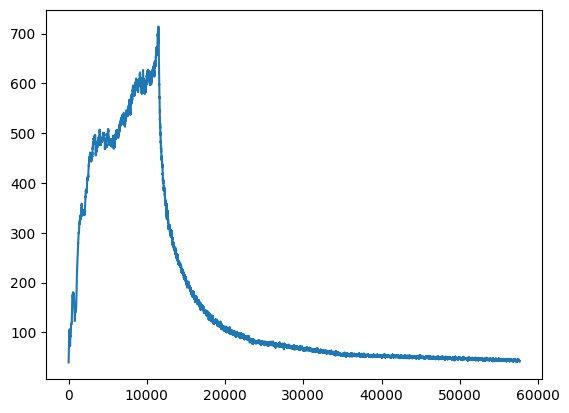

In [21]:
plt.plot(average_losses)

In [22]:
def translate_sentence(model, sentence, eng_tokenizer, hin_tokenizer, device, max_len=MAX_SENT_LEN):
    model.eval()  # Set model to evaluation mode
    
    # 1. Preprocess and Tokenize the input sentence
    sentence = sentence.lower().replace('!', '').replace('.', '').replace('?', '')
    tokens = eng_tokenizer.encode([sentence])[0]
    
    # 2. Pad the sequence (matching your training logic: left-padding)
    padding_idx = eng_tokenizer.word_index[eng_tokenizer.padding_token]
    padded_tokens = [padding_idx] * (max_len - len(tokens)) + tokens
    src_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device) # (1, max_len)

    with torch.no_grad():
        # 3. Pass through Encoder to get the context vector
        _, hidden = model.encoder(src_tensor)

        # 4. Prepare the Decoder input (starting with <|startoftext|>)
        start_idx = hin_tokenizer.word_index[hin_tokenizer.start_token]
        end_idx = hin_tokenizer.word_index[hin_tokenizer.end_token]
        
        input_token = torch.LongTensor([start_idx]).to(device)
        
        translated_indices = []

        # 5. Decode step-by-step
        for _ in range(max_len):
            output, hidden = model.decoder(input_token, hidden)
            
            # Get the word with the highest probability
            top1 = output.argmax(1)
            idx = top1.item()
            
            # Stop if we reach the <|endoftext|> token
            if idx == end_idx:
                break
                
            translated_indices.append(idx)
            input_token = top1 # Next input is the current prediction

    # 6. Convert indices back to words
    translated_sentence = hin_tokenizer.decode([translated_indices])[0]
    return translated_sentence

# --- Usage Example ---
input_str = "this is the bank of the river"
translation = translate_sentence(model, input_str, eng_tokenizer, hin_tokenizer, device)
print(f"Input: {input_str}")
print(f"Output: {translation}")

Input: this is the bank of the river
Output: 
